##Final Test Images

In [1]:
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile
from glob import glob

In [2]:
! git clone https://github.com/biplav-s/image-mask-estimate

Cloning into 'image-mask-estimate'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 25 (delta 1), reused 18 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.


## Downloading Kaggle Dataset

In [3]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akshaygupta123","key":"6a983d122ef7035e3a6d882dccc3a87b"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/face-mask-detection

 94% 374M/398M [00:01<00:00, 245MB/s]
100% 398M/398M [00:01<00:00, 226MB/s]


In [5]:
! mkdir train
! unzip face-mask-detection.zip -d train

Archive:  face-mask-detection.zip
  inflating: train/annotations/maksssksksss0.xml  
  inflating: train/annotations/maksssksksss1.xml  
  inflating: train/annotations/maksssksksss10.xml  
  inflating: train/annotations/maksssksksss100.xml  
  inflating: train/annotations/maksssksksss101.xml  
  inflating: train/annotations/maksssksksss102.xml  
  inflating: train/annotations/maksssksksss103.xml  
  inflating: train/annotations/maksssksksss104.xml  
  inflating: train/annotations/maksssksksss105.xml  
  inflating: train/annotations/maksssksksss106.xml  
  inflating: train/annotations/maksssksksss107.xml  
  inflating: train/annotations/maksssksksss108.xml  
  inflating: train/annotations/maksssksksss109.xml  
  inflating: train/annotations/maksssksksss11.xml  
  inflating: train/annotations/maksssksksss110.xml  
  inflating: train/annotations/maksssksksss111.xml  
  inflating: train/annotations/maksssksksss112.xml  
  inflating: train/annotations/maksssksksss113.xml  
  inflating: train

In [6]:
!mkdir -p Dataset/FaceMask/Images
!mkdir -p Dataset/FaceMask/Labels
!cp -rf /content/train/images/* Dataset/FaceMask/Images
!mkdir -p Dataset/images Dataset/labels

## Converting Data into Densenet Form

In [7]:
FILE_ROOT = "/content/train/"
IMAGE_PATH = FILE_ROOT + "images"  
ANNOTATIONS_PATH = FILE_ROOT + "annotations"

DATA_ROOT = "Dataset/"
LABELS_ROOT = DATA_ROOT + "FaceMask/Labels"
IMAGES_ROOT = DATA_ROOT + "FaceMask/Images"  

DEST_IMAGES_PATH = "images"
DEST_LABELS_PATH = "labels" 

In [8]:
classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']

In [9]:
def cord_converter(size, box):
    """
    convert xml annotation to darknet format coordinates
    :param size： [w,h]
    :param box: anchor box coordinates [upper-left x,uppler-left y,lower-right x, lower-right y]
    :return: converted [x,y,w,h]
    """
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

def save_file(img_jpg_file_name, size, img_box):
    save_file_name = LABELS_ROOT + '/' + img_jpg_file_name + '.txt'
    #print(save_file_name)
    file_path = open(save_file_name, "a+")
    for box in img_box:

        cls_num = classes.index(box[0])

        new_box = cord_converter(size, box[1:])

        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

    file_path.flush()
    file_path.close()

#accessing xml dom for converting image to.jpg and boxes and classes in .txt format    
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    #print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    # print("img_name:", img_name)
    # print("image_info:(w,h,c)", img_w, img_h, img_c)
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        # print("box:(c,xmin,ymin,xmax,ymax)", cls_name, x1, y1, x2, y2)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
    # print(img_box)

    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_file(img_xml_file, [img_w, img_h], img_box)

In [10]:
files = os.listdir(ANNOTATIONS_PATH)
for file in files:
    file_xml = file.split(".")
    get_xml_data(ANNOTATIONS_PATH, file_xml[0])

In [11]:
from sklearn.model_selection import train_test_split
image_list = os.listdir('Dataset/FaceMask/Images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=7)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=8)

print('total =',len(image_list))
print('train :',len(train_list))
print('val   :',len(val_list))
print('test  :',len(test_list))

total = 853
train : 682
val   : 85
test  : 86


In [12]:
#copying data for classifying into train,val,test split
def copy_data(file_list, img_labels_root, imgs_source, type):

    root_file = Path(DATA_ROOT + DEST_IMAGES_PATH + '/' + type)
    if not root_file.exists():
        os.makedirs(root_file)

    root_file = Path(DATA_ROOT + DEST_LABELS_PATH + '/' + type)
    if not root_file.exists():
        os.makedirs(root_file)

    for file in file_list:
        img_name = file.replace('.png', '')
        img_src_file = imgs_source + '/' + img_name + '.png'
        label_src_file = img_labels_root + '/' + img_name + '.txt'

        # Copy image
        DICT_DIR = DATA_ROOT + DEST_IMAGES_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.png'

        copyfile(img_src_file, img_dict_file)

        # Copy label
        DICT_DIR = DATA_ROOT + DEST_LABELS_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, img_dict_file)
        
copy_data(train_list, LABELS_ROOT, IMAGES_ROOT, "train")
copy_data(val_list,   LABELS_ROOT, IMAGES_ROOT, "val")
copy_data(test_list,  LABELS_ROOT, IMAGES_ROOT, "test")

In [13]:
# for giving data imformation to yolo
! mkdir -p data
! touch /content/data/facemask.yaml

In [14]:
!echo "train: /content/Dataset/images/train" >> /content/data/facemask.yaml
!echo "val:   /content/Dataset/images/val" >> /content/data/facemask.yaml
!echo "nc : 3" >> /content/data/facemask.yaml
!echo "names: ['With_Mask', 'Without_Mask', 'Incorrect_Mask']" >> /content/data/facemask.yaml

!cat /content/data/facemask.yaml

train: /content/Dataset/images/train
val:   /content/Dataset/images/val
nc : 3
names: ['With_Mask', 'Without_Mask', 'Incorrect_Mask']


## Yolov5 Model

In [15]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 4136 (delta 28), reused 27 (delta 14), pack-reused 4091
Receiving objects: 100% (4136/4136), 7.27 MiB | 35.27 MiB/s, done.
Resolving deltas: 100% (2796/2796), done.
/content/yolov5


In [ ]:
!pip install -r requirements.txt
%cd /content/yolov5

In [ ]:
!python train.py --img 320 --batch 16 --epochs 200 --data /content/data/facemask.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt

YOLOv5 v4.0-10-g1d1c056 torch 1.7.0+cu101 CUDA:0 (Tesla T4, 15079.75MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=False, cfg='models/yolov5s.yaml', data='/content/data/facemask.yaml', device='', epochs=200, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[320, 320], local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp2', single_cls=False, sync_bn=False, total_batch_size=16, weights='yolov5s.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
2021-01-11 09:19:11.802188: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momen

In [ ]:
!cp runs/train/exp2/weights/best.pt weights

In [ ]:
!python test.py --data /content/mask.yaml --img-size 320 --task test --conf-thres 0.3 --weights weights/best.pt 

Namespace(augment=False, batch_size=32, conf_thres=0.3, data='/content/mask.yaml', device='', exist_ok=False, img_size=320, iou_thres=0.6, name='exp', project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='test', verbose=False, weights=['best.pt'])
YOLOv5 v4.0-12-g509dd51 torch 1.7.0+cu101 CUDA:0 (Tesla T4, 15079.75MB)

Fusing layers... 
Model Summary: 224 layers, 7059304 parameters, 0 gradients, 16.3 GFLOPS
test: Scanning '/content/Dataset/labels/test' for images and labels... 86 found, 0 missing, 0 empty, 0 corrupted: 100% 86/86 [00:00<00:00, 665.14it/s]
test: New cache created: /content/Dataset/labels/test.cache
test: Scanning '/content/Dataset/labels/test.cache' for images and labels... 86 found, 0 missing, 0 empty, 0 corrupted: 100% 86/86 [00:00<00:00, 1051633.07it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 3/3 [00:02<00:00,  1.12it/s]
                 all         

In [45]:
!python detect.py --source /content/train/images/maksssksksss539.png --img-size 320 --conf 0.3 --weights weights/best.pt  --project /content

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.3, device='', exist_ok=False, img_size=320, iou_thres=0.45, name='exp', project='/content', save_conf=False, save_txt=False, source='/content/train/images/maksssksksss539.png', update=False, view_img=False, weights=['best.pt'])
YOLOv5 v4.0-14-gb75c432 torch 1.7.0+cu101 CUDA:0 (Tesla T4, 15079.75MB)

Fusing layers... 
Model Summary: 224 layers, 7059304 parameters, 0 gradients, 16.3 GFLOPS
image 1/1 /content/train/images/maksssksksss539.png: 224x320 41 With_Masks, 1 Without_Masks, Done. (0.010s)
Results saved to /content/exp2
Done. (0.043s)


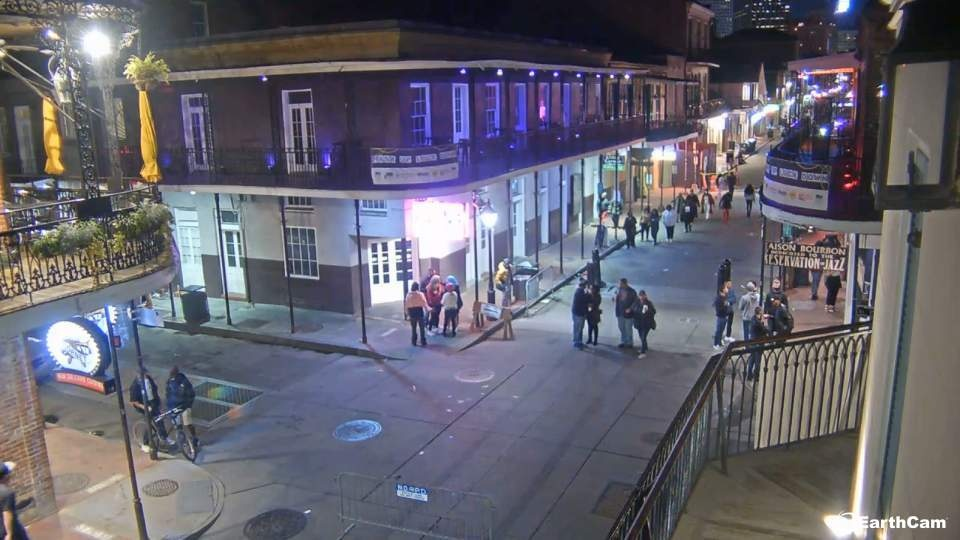

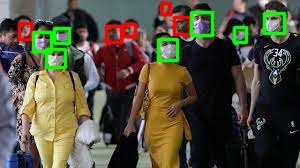

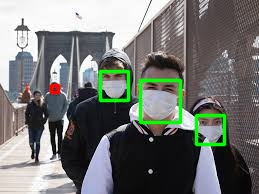

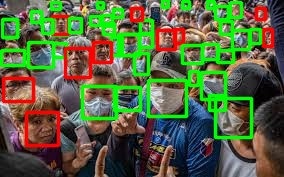

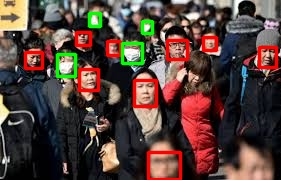

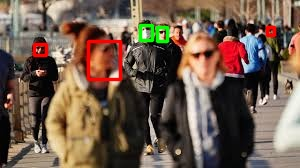

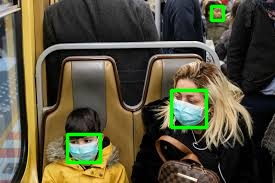

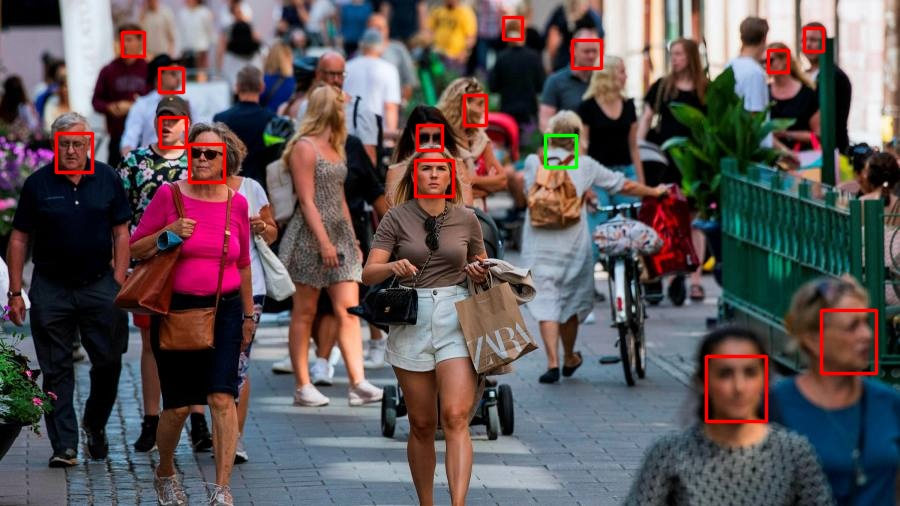

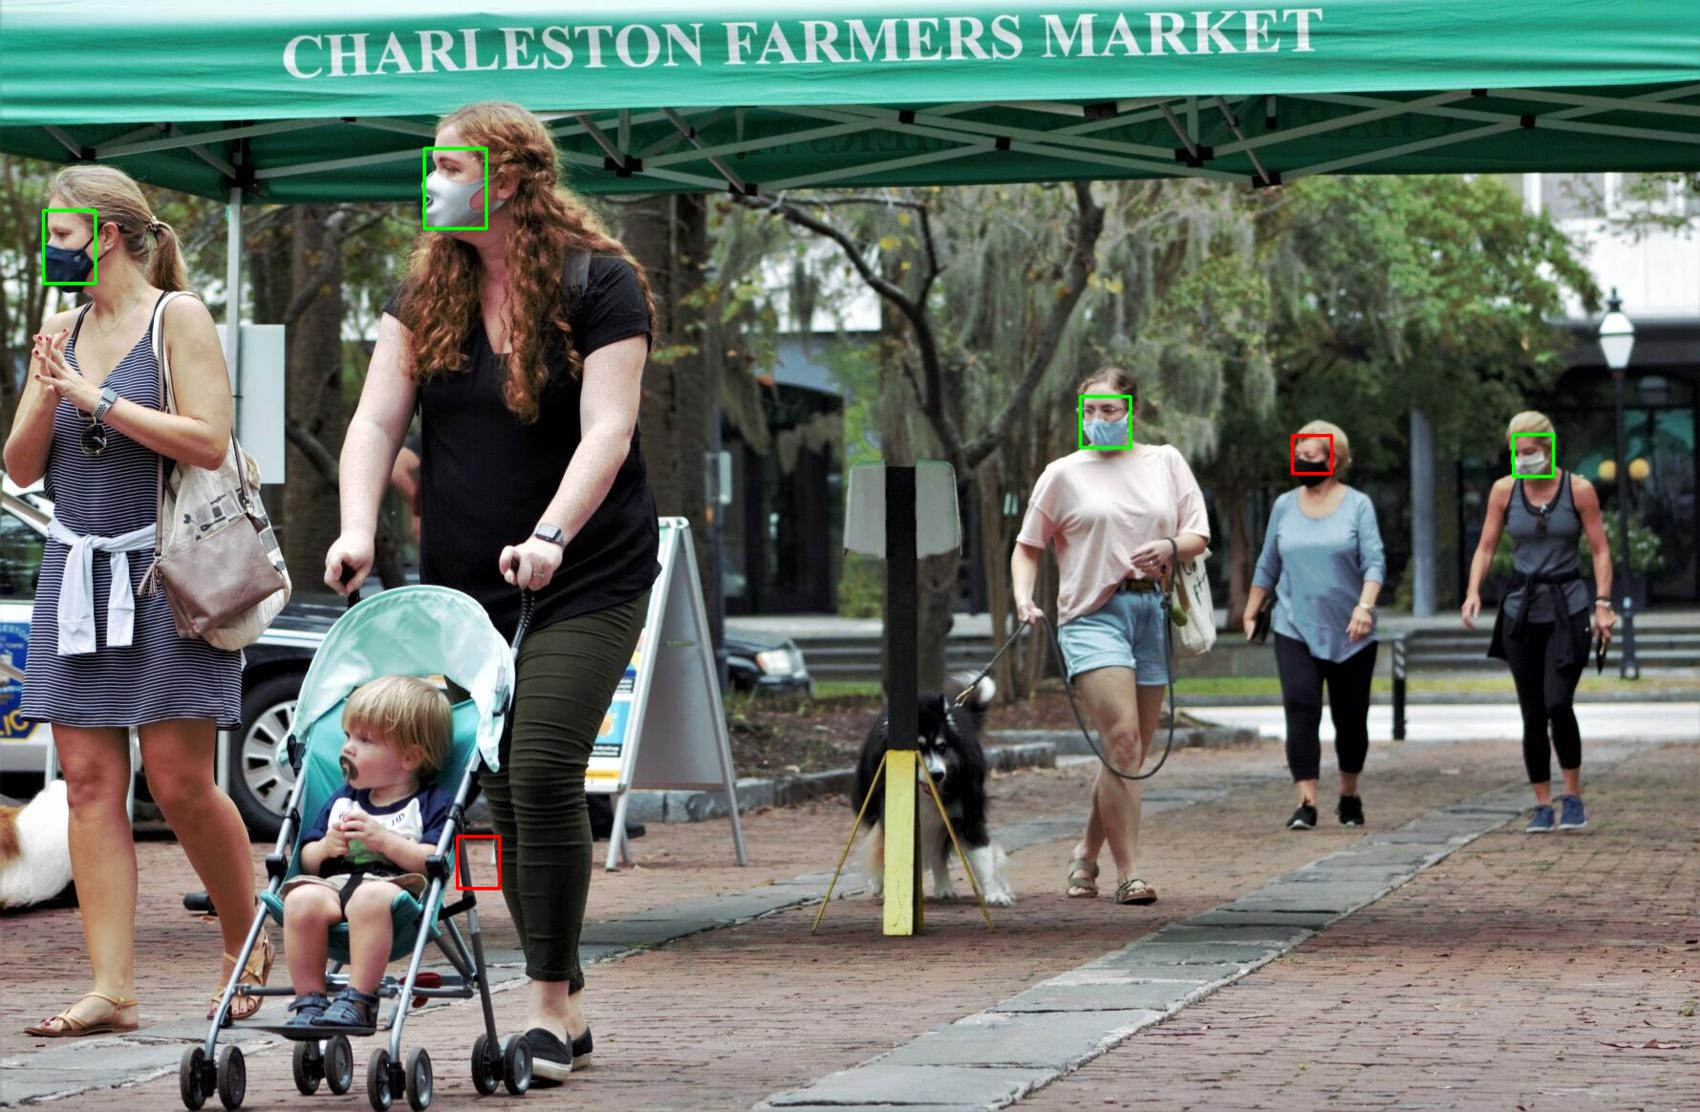

In [ ]:
for i in range(1,10):
  path ='/content/Yolov5_tuned/exp1'+str(i)+'/'+ str(i)+'.jpg'
  img=cv2.imread(path) 
  cv2_imshow(img)

##Testing Utils

In [19]:
from models.experimental import attempt_load
model = attempt_load('/content/yolov5/best.pt').autoshape() 

Fusing layers... 
Adding autoShape... 


In [21]:
def calc_iou( gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        
        return 0.0
    
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

In [22]:
def calc_precision_recall(image_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_positive=0
    false_positive=0
    false_negative=0
    for img_id, res in image_results.items():
        true_positive +=res['true_positive']
        false_positive += res['false_positive']
        false_negative += res['false_negative']
        try:
            precision = true_positive/(true_positive+ false_positive)
        except ZeroDivisionError:
            precision=0.0
        try:
            recall = true_positive/(true_positive + false_negative)
        except ZeroDivisionError:
            recall=0.0
    return (precision, recall)

In [49]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax,cls,image_id]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    all_pred_indices= range(len(pred_boxes))
    all_gt_indices=range(len(gt_boxes))
    if len(all_pred_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    if len(all_gt_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou= calc_iou(gt_box[:4], pred_box[:4])
            
            if iou >iou_thr and pred_box[4]==gt_box[4]:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
    iou_sort = np.argsort(ious)[::1]
    if len(iou_sort)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp= len(gt_match_idx)
        fp= len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

##Testing

In [56]:
img_results = {}
images = glob('/content/Dataset/images/test/*')
for i in images:
  gt,pred=[],[]
  gt_mask,pred_mask,gt_nonm,pred_nonm=0,0,0,0 
  img = cv2.imread(i)[:, :, ::-1]
  prediction = model(img, size=640)
  img_name = str(i.split('/')[-1][:-4])
  img_path = '/content/train/annotations/'+img_name+'.xml'

  for boxes in prediction.xyxy[0]:
    box=boxes.numpy()
    #print(box)
    if box[4]>0.3:
      if int(box[5])==1:
        pred_nonm  =pred_nonm+1
      else:
        pred_mask  =pred_mask+1
      pred.append([int(box[0]),int(box[1]),int(box[2]),int(box[3]),int(box[5]),int(img_name[12:])])
  dom = parse(img_path)
  root = dom.documentElement
  objects = root.getElementsByTagName("object")
  for box in objects:
    cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
    x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
    y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
    x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
    y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
    cls_num = classes.index(cls_name)
    if cls_num==1:
        gt_nonm=gt_nonm+1
    else:
        gt_mask=gt_mask+1
    gt.append([x1, y1, x2, y2,classes.index(cls_name),int(img_name[12:])])
  img_results[img_name] = get_single_image_results(gt, pred, iou_thr=0.45)
  
  res_string_1 = f' >Ground_Truth: {gt_mask} people wearing mask and {gt_nonm} people are not wearing mask; Proportion: {gt_mask/(gt_mask+gt_nonm):2.3f}'
  if (pred_mask+pred_nonm)!=0:
    res_string_2 = f' >Prediction: {pred_mask} people wearing mask and {pred_nonm} people are not wearing mask; Proportion: {pred_mask/(pred_mask+pred_nonm):2.3f}'
  else:
    res_string_2 = ' >Prediction: Not identify any People'

  print(f'{img_name}:') 
  print(res_string_1)
  print(res_string_2)

prec, rec = calc_precision_recall(img_results)
print('')
print(f' >Precision: {prec}; >Recall: {rec}')

maksssksksss372:
 >Ground_Truth: 2 people wearing mask and 0 people are not wearing mask; Proportion: 1.000
 >Prediction: 2 people wearing mask and 0 people are not wearing mask; Proportion: 1.000
maksssksksss539:
 >Ground_Truth: 40 people wearing mask and 1 people are not wearing mask; Proportion: 0.976
 >Prediction: 42 people wearing mask and 1 people are not wearing mask; Proportion: 0.977
maksssksksss173:
 >Ground_Truth: 2 people wearing mask and 0 people are not wearing mask; Proportion: 1.000
 >Prediction: 2 people wearing mask and 0 people are not wearing mask; Proportion: 1.000
maksssksksss689:
 >Ground_Truth: 1 people wearing mask and 0 people are not wearing mask; Proportion: 1.000
 >Prediction: 1 people wearing mask and 0 people are not wearing mask; Proportion: 1.000
maksssksksss17:
 >Ground_Truth: 1 people wearing mask and 0 people are not wearing mask; Proportion: 1.000
 >Prediction: 1 people wearing mask and 0 people are not wearing mask; Proportion: 1.000
maksssksksss59